In [8]:
import re

import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def extract_data(filename):
    with open(filename) as infile:
        content = infile.read()
    
    model = re.findall(r'Model\s*:\s*(.*)', content)
    wer = re.findall(r'WER\s*:\s*(.*)', content)
    rtf = re.findall(r'RTF\s*:\s*(.*)', content)
    memory = re.findall(r'GPU memory while loaded \[MB\]\s*:\s*(.*)', content)

    data = {
        'model': model,
        'wer': wer,
        'rtf': rtf,
        'memory': memory
    }

    return pd.DataFrame(data)



In [10]:
data = extract_data('whisper_results.txt')
models = data['model'].unique()

tiny_flash = data[data['model'] == models[0]].reset_index(drop=True)
base_flash = data[data['model'] == models[1]].reset_index(drop=True)
small_flash = data[data['model'] == models[2]].reset_index(drop=True)
medium_flash = data[data['model'] == models[3]].reset_index(drop=True)
large_flash = data[data['model'] == models[4]].reset_index(drop=True)
tiny = data[data['model'] == models[5]].reset_index(drop=True)
base = data[data['model'] == models[6]].reset_index(drop=True)
small = data[data['model'] == models[7]].reset_index(drop=True)
medium = data[data['model'] == models[8]].reset_index(drop=True)
large = data[data['model'] == models[9]].reset_index(drop=True)

models = [tiny_flash, base_flash, small_flash, medium_flash, large_flash, tiny, base, small, medium, large]

for model in models:
    model.index = model.index + 1

# rename all models by removing openai/whisper- prefix
for model in models:
    model['model'] = model['model'].str.replace('openai/whisper-', '')

In [11]:
import soundfile as sf
import os

home_dir = os.path.expanduser('~')
audio_files = os.listdir(os.path.join(home_dir, 'audio_files'))
audio_files.sort()

# compute the duration of all audio files

durations = []

for audio_file in audio_files:
    durations.append(sf.info(os.path.join(home_dir, 'audio_files', audio_file)).duration)

for i in range(len(models)):
    models[i]['duration'] = durations

# create a new column inference_time which is the product of the duration and the rtf

for i in range(len(models)):
    models[i]['inference_time'] = models[i]['duration'] * models[i]['rtf'].astype(float)




In [12]:
print(round(models[4]['wer'].astype(float).mean(), 3))
print(round(models[4]['rtf'].astype(float).mean(), 3))
print(round(models[4]['memory'].astype(float).mean(), 3))


0.157
0.036
3096.211


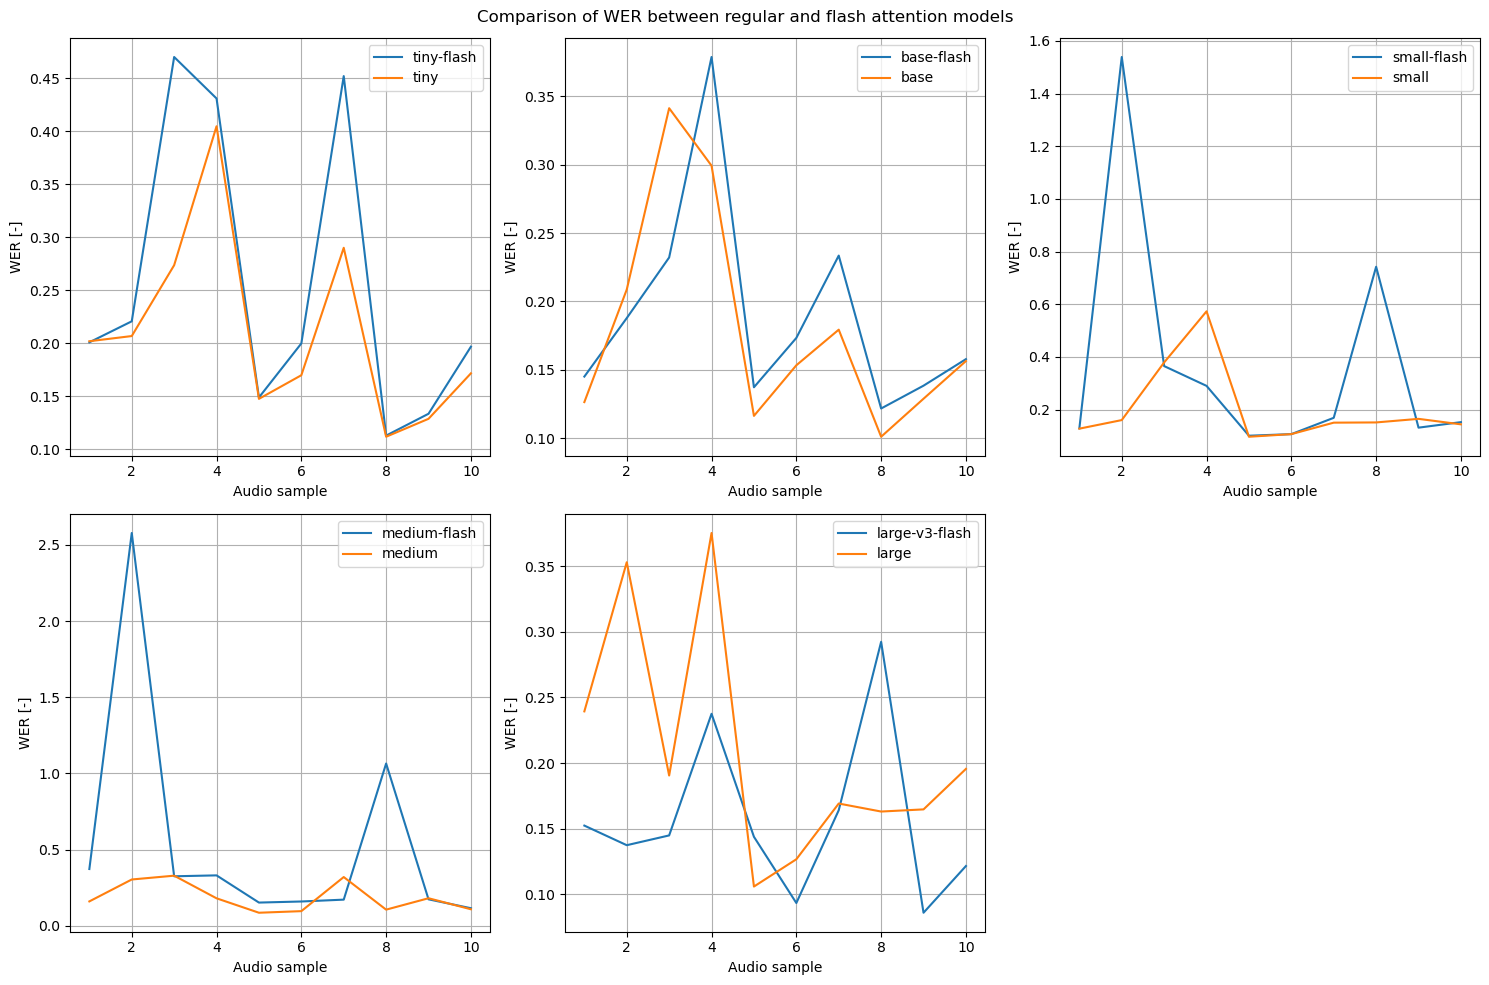

In [13]:
# plot wer

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the first five subplots
for i in range(5):
    row = i // 3
    col = i % 3
    models[i]['wer'].astype(float).plot(ax=axs[row, col], label=models[i]['model'][1])
    models[i+len(models)//2]['wer'].astype(float).plot(ax=axs[row, col], label=models[i+len(models)//2]['model'][1])
    axs[row, col].grid()
    axs[row, col].legend()

# Remove the last subplot
fig.delaxes(axs[1, 2])

# Remove titles over the subplots
for ax in axs.flat:
    ax.set_title('')
    ax.set_xlabel('Audio sample')
    ax.set_ylabel('WER [-]')

# Create one big title for the full figure
fig.suptitle('Comparison of WER between regular and flash attention models')

plt.tight_layout()
plt.show()

# export plot to pdf
# fig.savefig('whisper_wer.pdf')

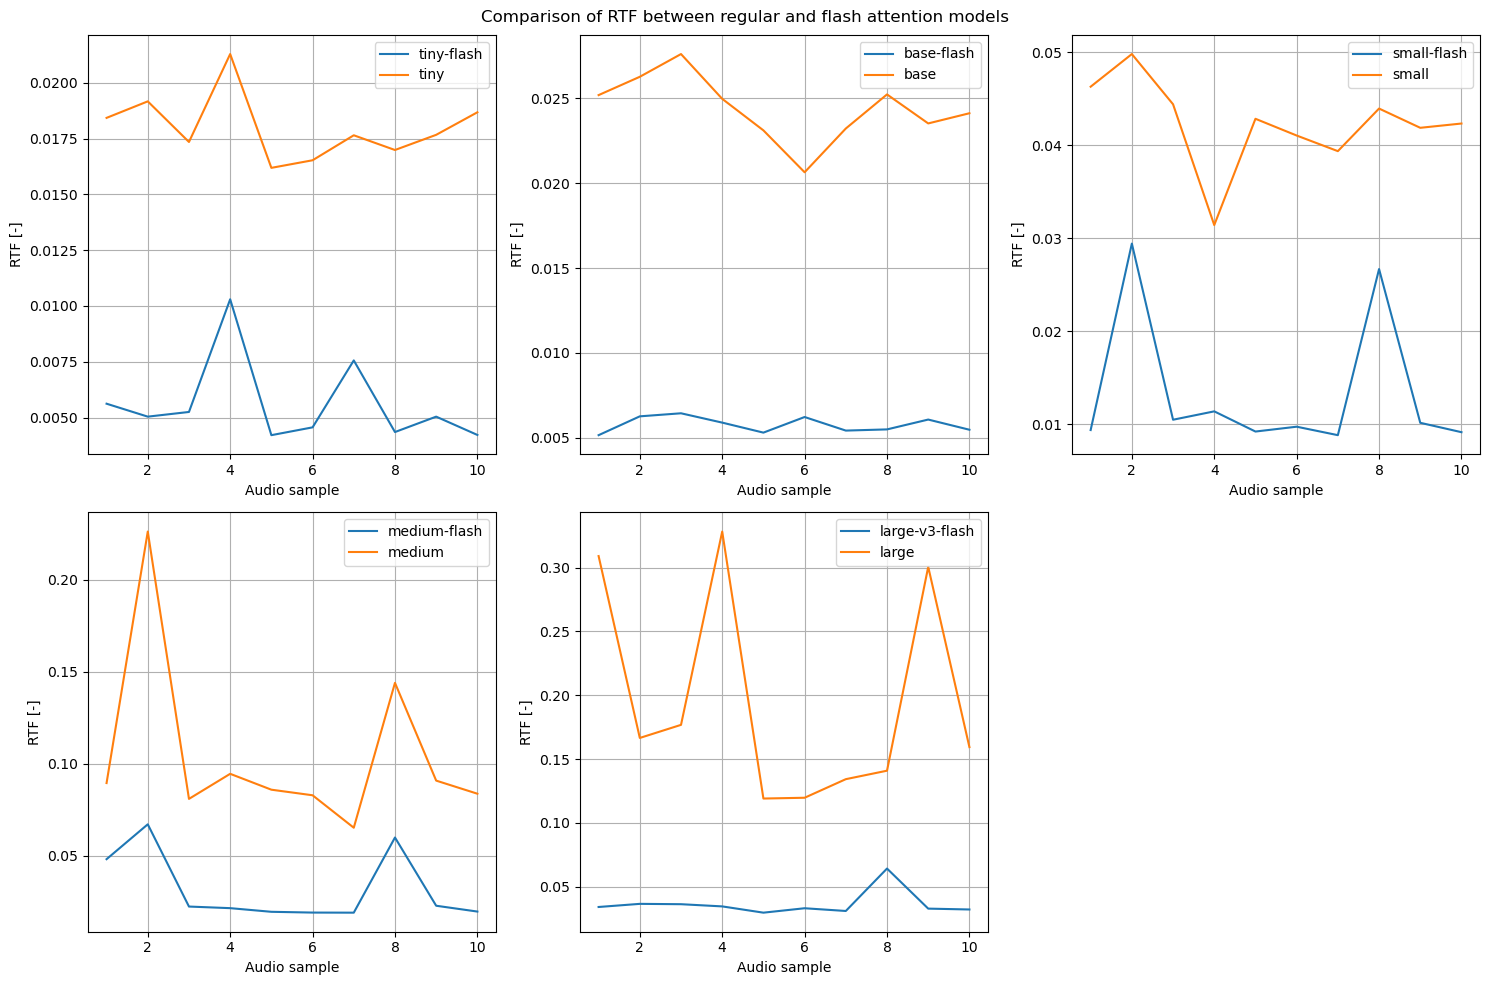

In [14]:
# plot rtf

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the first five subplots
for i in range(5):
    row = i // 3
    col = i % 3
    models[i]['rtf'].astype(float).plot(ax=axs[row, col], label=models[i]['model'][1])
    models[i+len(models)//2]['rtf'].astype(float).plot(ax=axs[row, col], label=models[i+len(models)//2]['model'][1])
    axs[row, col].grid()
    axs[row, col].legend()

# Remove the last subplot
fig.delaxes(axs[1, 2])

# Remove titles over the subplots
for ax in axs.flat:
    ax.set_title('')
    ax.set_xlabel('Audio sample')
    ax.set_ylabel('RTF [-]')

# Create one big title for the full figure
fig.suptitle('Comparison of RTF between regular and flash attention models')

plt.tight_layout()
plt.show()

# export plot to pdf
# fig.savefig('whisper_rtf.pdf')


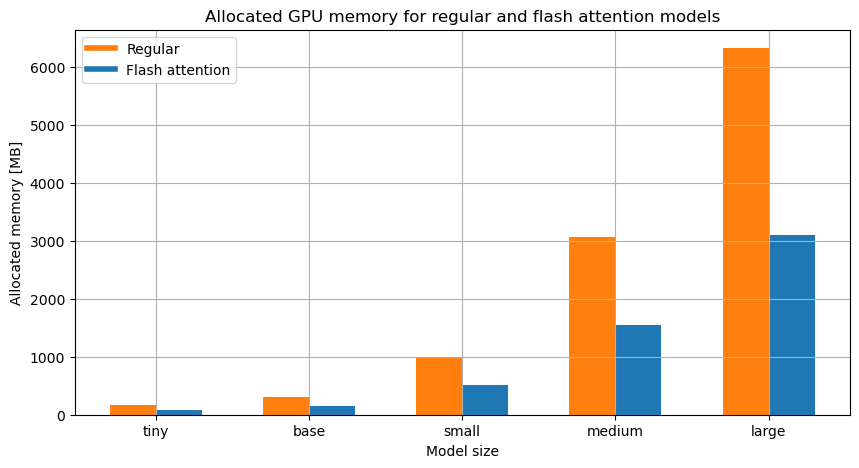

In [15]:
# plot memory

fig, ax = plt.subplots(figsize=(10, 5))

# Define the width of the group
width = 0.3

# Separate models into two groups
models_regular = [model for model in models if 'flash' not in model['model'][1]]
models_flash = [model for model in models if 'flash' in model['model'][1]]

# Plot regular models
for i, model in enumerate(models_regular):
    ax.bar(i - width/2, model['memory'].astype(float), width, color='tab:orange')

# Plot flash models
for i, model in enumerate(models_flash):
    ax.bar(i + width/2, model['memory'].astype(float), width, color='tab:blue')

# Set the x-ticks to be the middle of the groups
ax.set_xticks(range(len(models)//2))
ax.set_xticklabels([model['model'][1] for model in models_regular])
ax.set_xlabel('Model size')
ax.set_ylabel('Allocated memory [MB]')
ax.set_title('Allocated GPU memory for regular and flash attention models')

# Create a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:orange', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
ax.legend(custom_lines, ['Regular', 'Flash attention'])

ax.grid()

plt.show()

# export plot to pdf
# fig.savefig('whisper_memory.pdf')

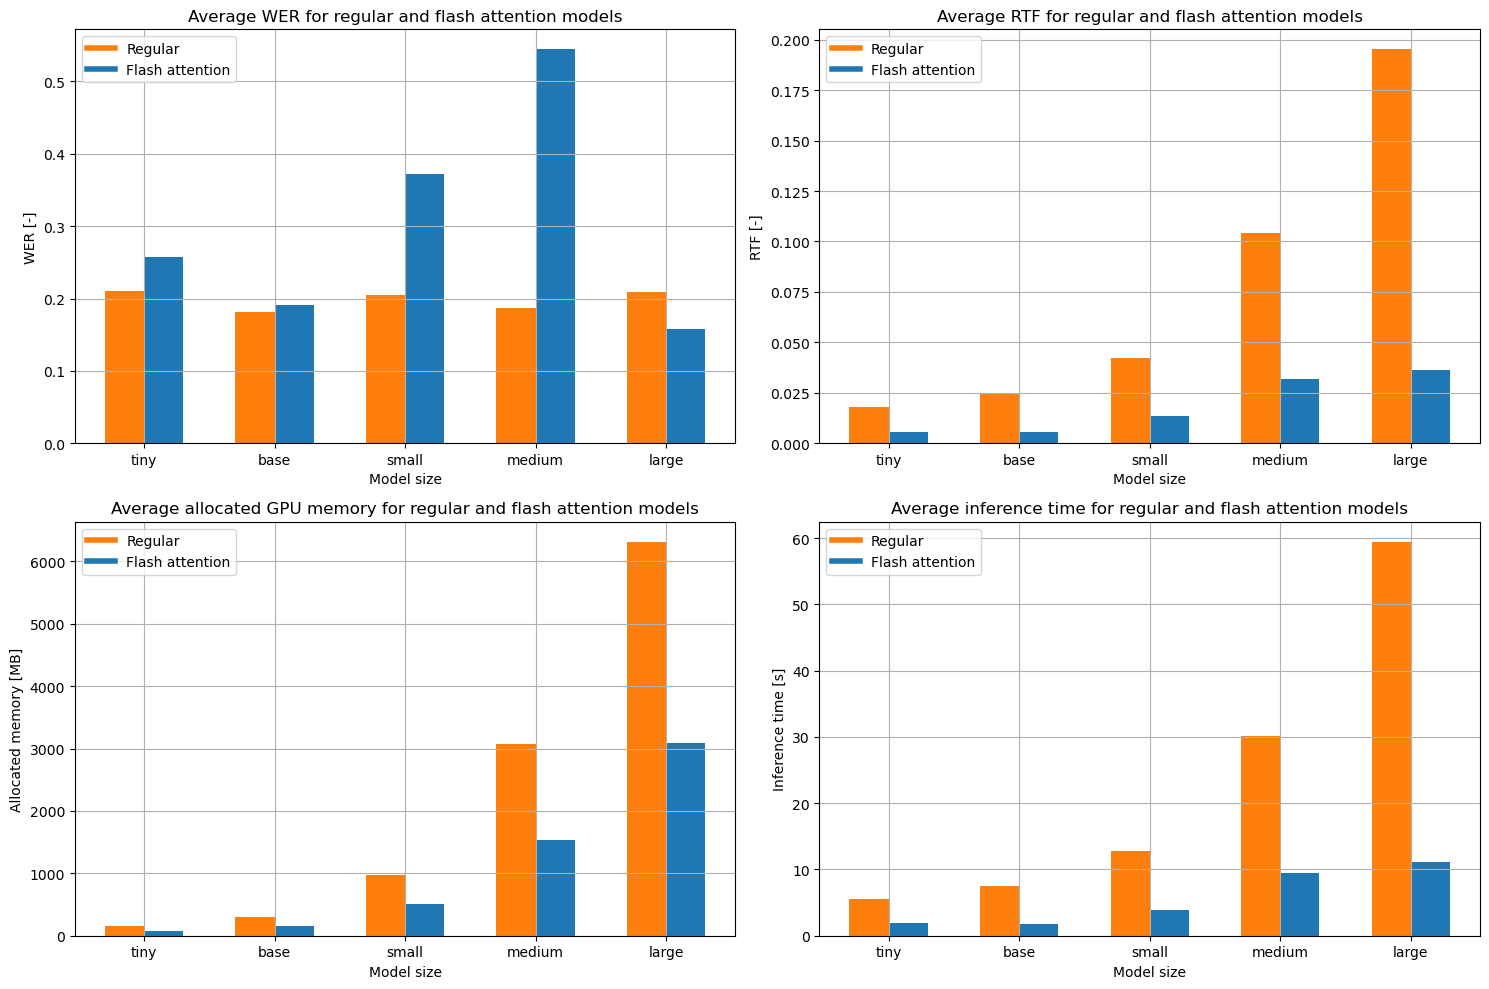

RTF:  0.272
RTF large:  0.186
Memory:  0.5
Memory large:  0.49
Inf. time:  0.278
Inf. time large:  0.187
WER large flash:  0.157


In [30]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define the width of the group
width = 0.3

# Separate models into two groups
models_regular = [model for model in models if 'flash' not in model['model'][1]]
models_flash = [model for model in models if 'flash' in model['model'][1]]

# Define metrics
metrics = ['wer', 'rtf', 'memory', 'inference_time']
titles = ['Average WER for regular and flash attention models', 'Average RTF for regular and flash attention models', 'Average allocated GPU memory for regular and flash attention models', 'Average inference time for regular and flash attention models']
ylabels = ['WER [-]', 'RTF [-]', 'Allocated memory [MB]', 'Inference time [s]']

# Plot each metric
for i, (ax, metric, title, ylabel) in enumerate(zip(axs.flat, metrics, titles, ylabels)):
    # Plot regular models
    for j, model in enumerate(models_regular):
        ax.bar(j - width/2, model[metric].astype(float).mean(), width, color='tab:orange')

    # Plot flash models
    for j, model in enumerate(models_flash):
        ax.bar(j + width/2, model[metric].astype(float).mean(), width, color='tab:blue')

    # Set the x-ticks to be the middle of the groups
    ax.set_xticks(range(len(models)//2))
    ax.set_xticklabels([model['model'][1].replace('flash', '') for model in models_regular])
    ax.set_xlabel('Model size')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()

# Create a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:orange', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
axs[0, 0].legend(custom_lines, ['Regular', 'Flash attention'])
axs[0, 1].legend(custom_lines, ['Regular', 'Flash attention'])
axs[1, 0].legend(custom_lines, ['Regular', 'Flash attention'])
axs[1, 1].legend(custom_lines, ['Regular', 'Flash attention'])


plt.tight_layout()
plt.show()

# export plot to pdf
# fig.savefig('whisper_avg.pdf')

# numbers of thesis

# for RTF, memory and inference time, compute the ratio between the flash and regular attention models, and print the average ratio

# RTF
ratios_rtf = []
for i in range(len(models)//2):
    ratios_rtf.append(models[i]['rtf'].astype(float).mean() / models[i+len(models)//2]['rtf'].astype(float).mean())

print("RTF: ", round(sum(ratios_rtf) / len(ratios_rtf), 3))
# print the ration between the large models
print("RTF large: ", round(models[4]['rtf'].astype(float).mean() / models[9]['rtf'].astype(float).mean(), 3))

# memory
ratios_memory = []
for i in range(len(models)//2):
    ratios_memory.append(models[i]['memory'].astype(float).mean() / models[i+len(models)//2]['memory'].astype(float).mean())

print("Memory: ", round(sum(ratios_memory) / len(ratios_memory), 3))
# print the ration between the large models
print("Memory large: ", round(models[4]['memory'].astype(float).mean() / models[9]['memory'].astype(float).mean(), 3))

# inference time
ratios_inference_time = []
for i in range(len(models)//2):
    ratios_inference_time.append(models[i]['inference_time'].astype(float).mean() / models[i+len(models)//2]['inference_time'].astype(float).mean())

print("Inf. time: ", round(sum(ratios_inference_time) / len(ratios_inference_time), 3))
# print the ration between the large models
print("Inf. time large: ", round(models[4]['inference_time'].astype(float).mean() / models[9]['inference_time'].astype(float).mean(), 3))

# print average WER of large model with flash attention
print("WER large flash: ", round(models[4]['wer'].astype(float).mean(), 3))

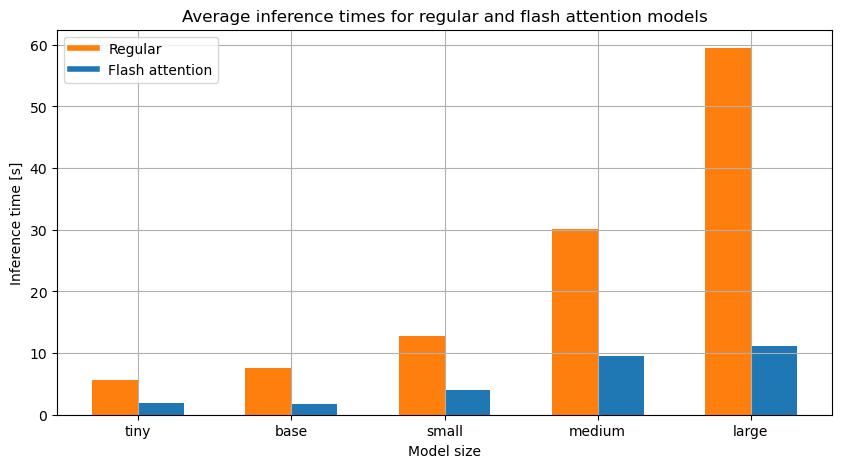

In [17]:
# plot the inference time for each model the same way as the memory plot

fig, ax = plt.subplots(figsize=(10, 5))

# Define the width of the group
width = 0.3

# Separate models into two groups
models_regular = [model for model in models if 'flash' not in model['model'][1]]
models_flash = [model for model in models if 'flash' in model['model'][1]]

# Plot regular models
for i, model in enumerate(models_regular):
    ax.bar(i - width/2, model['inference_time'].mean(), width, color='tab:orange')

# Plot flash models
for i, model in enumerate(models_flash):
    ax.bar(i + width/2, model['inference_time'].mean(), width, color='tab:blue')

# Set the x-ticks to be the middle of the groups
ax.set_xticks(range(len(models)//2))
ax.set_xticklabels([model['model'][1] for model in models_regular])
ax.set_title('Average inference times for regular and flash attention models')
ax.set_xlabel('Model size')
ax.set_ylabel('Inference time [s]')
ax.grid()

# Create a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:orange', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
ax.legend(custom_lines, ['Regular', 'Flash attention'])

plt.show()

# export plot to pdf
# fig.savefig('whisper_avg_inf_time.pdf')

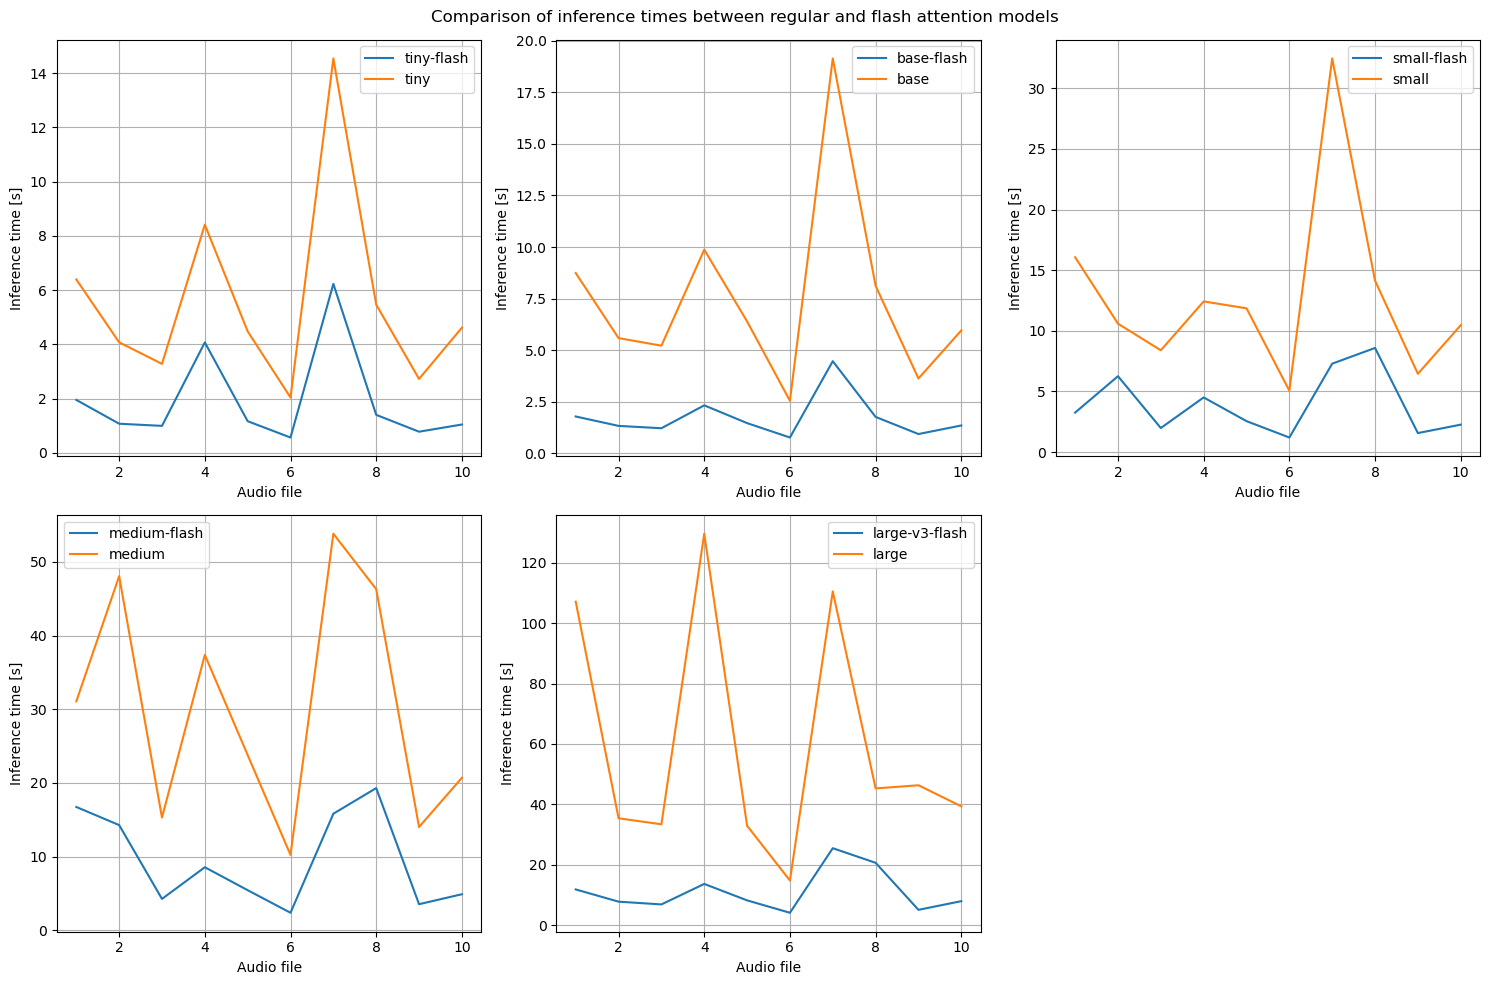

In [18]:
# plot the inference time for each model the same way as the wer plot

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the first five subplots
for i in range(5):
    row = i // 3
    col = i % 3
    models[i]['inference_time'].plot(ax=axs[row, col], label=models[i]['model'][1])
    models[i+len(models)//2]['inference_time'].plot(ax=axs[row, col], label=models[i+len(models)//2]['model'][1])
    axs[row, col].grid()
    axs[row, col].legend()

# Remove the last subplot
fig.delaxes(axs[1, 2])

# Remove titles over the subplots
for ax in axs.flat:
    ax.set_title('')
    ax.set_xlabel('Audio file')
    ax.set_ylabel('Inference time [s]')

# Create one big title for the full figure
fig.suptitle('Comparison of inference times between regular and flash attention models')

plt.tight_layout()
plt.show()

# export plot to pdf
# fig.savefig('whisper_inf_time.pdf')